In [7]:
# Cell 1: Build trial matrices, run SVM decoding, and save results

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix
import glob
from pathlib import Path
import helperFunc

# ============================================================
# Setup paths
# ============================================================
cwd = Path.cwd()
savepath = cwd / "Figure3G"
savepath.mkdir(exist_ok=True)

masterlistpath = cwd / "masterlist_experiment1task.csv"
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

folderpath_prelearning = cwd / "data_timewarped/prelearning"
folderpath_postlearning = cwd / "data_timewarped/postlearning"
catchtrialfolderpath = cwd / "data_timewarped/catchtrials"

savename = "experiment1"
areas = [["LA"], ["BLA"], ["PIR"]]
restrictneuronnum = 50
iterationstorun = 100

saveaccuracy = np.zeros((len(areas), 40, iterationstorun, 2))
saveaccuracyshuffle = np.zeros((len(areas), 40, iterationstorun, 2))

parameters = [
    ["iterationstorun", iterationstorun],
    ["restrictneuronnum", restrictneuronnum],
    ["masterlistpath", str(masterlistpath)],
]

# ============================================================
# Functions
# ============================================================
def runSVM_4animals_onetimepoint(frvalues, labels):
    """Run linear SVM with stratified 5-fold CV on single time bin data."""
    X, y = frvalues, labels
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    svc = svm.SVC(kernel="linear")

    ypred = np.zeros(y.shape)
    for trainidx, testidx in skf.split(X, y):
        scaler = StandardScaler()
        Xtrain, Xtest = X[trainidx], X[testidx]
        ytrain, ytest = y[trainidx], y[testidx]

        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        svc.fit(Xtrain, ytrain)
        ypred[testidx] = svc.predict(Xtest)

    return metrics.accuracy_score(y, ypred), confusion_matrix(y, ypred)


def calculate4animalneuronmatrix(folderpath, catchtrialfolderpath, neuronlist):
    """Build firing rate and label matrices for 4 animal categories."""
    frmatrix_rewarded = np.full((100, 40, len(neuronlist)), np.nan)
    frmatrix_unrewarded = np.full((100, 40, len(neuronlist)), np.nan)
    frmatrix_female = np.full((100, 40, len(neuronlist)), np.nan)
    frmatrix_novelmale = np.full((100, 40, len(neuronlist)), np.nan)

    labelmatrix_rewarded = np.full((200, neuronlist.shape[0]), np.nan)
    labelmatrix_unrewarded = np.full((200, neuronlist.shape[0]), np.nan)
    labelmatrix_female = np.full((200, neuronlist.shape[0]), np.nan)
    labelmatrix_novelmale = np.full((200, neuronlist.shape[0]), np.nan)

    for n, neuron in enumerate(neuronlist):
        rat, date, area, unitid = neuron[:4]
        pathname = f"{rat}_{date}_*_{unitid}"

        reward = np.load(glob.glob(str(folderpath / f"{pathname}_rewarded.npy"))[0])
        unreward = np.load(glob.glob(str(folderpath / f"{pathname}_unrewarded.npy"))[0])
        female = np.load(glob.glob(str(catchtrialfolderpath / f"{pathname}_female.npy"))[0])
        novelmale = np.load(glob.glob(str(catchtrialfolderpath / f"{pathname}_novelmale.npy"))[0])

        frmatrix_rewarded[:reward.shape[0], :, n] = reward
        frmatrix_unrewarded[:unreward.shape[0], :, n] = unreward
        frmatrix_female[:female.shape[0], :, n] = female
        frmatrix_novelmale[:novelmale.shape[0], :, n] = novelmale

        labelmatrix_rewarded[:reward.shape[0], n] = 1
        labelmatrix_unrewarded[:unreward.shape[0], n] = 0
        labelmatrix_female[:female.shape[0], n] = 2
        labelmatrix_novelmale[:novelmale.shape[0], n] = 3

    return (frmatrix_rewarded, frmatrix_unrewarded, labelmatrix_rewarded, labelmatrix_unrewarded,
            frmatrix_female, frmatrix_novelmale, labelmatrix_female, labelmatrix_novelmale)

# ============================================================
# Main decoding loop
# ============================================================
for a, area in enumerate(areas):
    print(f"Running decoding for area {area}...")
    neuronstouse = masterlist[np.isin(masterlist[:, 2], area)]

    # Build FR and label matrices
    (prefrmatrix_rewarded, prefrmatrix_unrewarded, prelabelmatrix_rewarded, prelabelmatrix_unrewarded,
     frmatrix_female, frmatrix_novelmale, labelmatrix_female, labelmatrix_novelmale) = calculate4animalneuronmatrix(
        folderpath_prelearning, catchtrialfolderpath, neuronstouse)

    (postfrmatrix_rewarded, postfrmatrix_unrewarded, postlabelmatrix_rewarded, postlabelmatrix_unrewarded,
     _, _, _, _) = calculate4animalneuronmatrix(
        folderpath_postlearning, catchtrialfolderpath, neuronstouse)

    # now we need to select the data with a specific number of neurons and a specific number of trials to create a balanced dataset
    prerewardedcountperneuron = np.count_nonzero(prelabelmatrix_rewarded == 1, axis=0)
    preunrewardedcountperneuron = np.count_nonzero(prelabelmatrix_unrewarded == 0, axis=0)
    postrewardedcountperneuron = np.count_nonzero(postlabelmatrix_rewarded == 1, axis=0)
    postunrewardedcountperneuron = np.count_nonzero(postlabelmatrix_unrewarded == 0, axis=0)
    femalecountperneuron = np.count_nonzero(labelmatrix_female == 2, axis=0)
    novelmalecountperneuron = np.count_nonzero(labelmatrix_novelmale == 3, axis=0)

    # detect female or novelmale neurons with fewer than 5 trials and remove from dataset
    neuronstoremove = np.unique(np.hstack((np.where(femalecountperneuron < 5), np.where(novelmalecountperneuron < 5))))

    prefrmatrix_rewarded = np.delete(prefrmatrix_rewarded, neuronstoremove, axis=2)
    prefrmatrix_unrewarded = np.delete(prefrmatrix_unrewarded, neuronstoremove, axis=2)
    postfrmatrix_rewarded = np.delete(postfrmatrix_rewarded, neuronstoremove, axis=2)
    postfrmatrix_unrewarded = np.delete(postfrmatrix_unrewarded, neuronstoremove, axis=2)
    frmatrix_female = np.delete(frmatrix_female, neuronstoremove, axis=2)
    frmatrix_novelmale = np.delete(frmatrix_novelmale, neuronstoremove, axis=2)

    prelabelmatrix_rewarded = np.delete(prelabelmatrix_rewarded, neuronstoremove, axis=1)
    prelabelmatrix_unrewarded = np.delete(prelabelmatrix_unrewarded, neuronstoremove, axis=1)
    postlabelmatrix_rewarded = np.delete(postlabelmatrix_rewarded, neuronstoremove, axis=1)
    postlabelmatrix_unrewarded = np.delete(postlabelmatrix_unrewarded, neuronstoremove, axis=1)
    labelmatrix_female = np.delete(labelmatrix_female, neuronstoremove, axis=1)
    labelmatrix_novelmale = np.delete(labelmatrix_novelmale, neuronstoremove, axis=1)
    neuronstouse = np.delete(neuronstouse, neuronstoremove, axis=0)

    print(str(neuronstoremove.shape[0]) + ' neurons removed due to insufficient trials')

    femalecountperneuron = np.count_nonzero(labelmatrix_female == 2, axis=0)
    novelmalecountperneuron = np.count_nonzero(labelmatrix_novelmale == 3, axis=0)
    prerewardedcountperneuron = np.count_nonzero(prelabelmatrix_rewarded == 1, axis=0)
    preunrewardedcountperneuron = np.count_nonzero(prelabelmatrix_unrewarded == 0, axis=0)
    postrewardedcountperneuron = np.count_nonzero(postlabelmatrix_rewarded == 1, axis=0)
    postunrewardedcountperneuron = np.count_nonzero(postlabelmatrix_unrewarded == 0, axis=0)

    mininstance = np.min(
        [np.min(prerewardedcountperneuron), np.min(preunrewardedcountperneuron),
         np.min(postrewardedcountperneuron), np.min(postunrewardedcountperneuron),
         np.min(femalecountperneuron), np.min(novelmalecountperneuron)])
    print('Minimum Trial Count = ' + str(mininstance))

    # Confusion matrices
    savecmatrix = np.zeros((4, 4, 40, 2))
    savecmatrixshuffle = np.zeros((4, 4, 40, 2))

    for x in range(iterationstorun):
        # select a new group of neurons per iteration
        if restrictneuronnum == 'nan':
            neuronidx = np.arange(neuronstouse.shape[0])
        else:
            neuronidx = np.random.choice(neuronstouse.shape[0], restrictneuronnum, replace=False)

        for n, nn in enumerate(neuronidx):
            preselectrewarded = np.random.choice(prerewardedcountperneuron[nn], mininstance, replace=False)
            preselectunrewarded = np.random.choice(preunrewardedcountperneuron[nn], mininstance, replace=False)
            postselectrewarded = np.random.choice(postrewardedcountperneuron[nn], mininstance, replace=False)
            postselectunrewarded = np.random.choice(postunrewardedcountperneuron[nn], mininstance, replace=False)
            selectfemale = np.random.choice(femalecountperneuron[nn], mininstance, replace=False)
            selectnovelmale = np.random.choice(novelmalecountperneuron[nn], mininstance, replace=False)

            if n == 0:
                prefrvalues = np.vstack((prefrmatrix_rewarded[preselectrewarded, :, nn],
                                      prefrmatrix_unrewarded[preselectunrewarded, :, nn],
                                         frmatrix_novelmale[selectnovelmale, :, nn],
                                      frmatrix_female[selectfemale, :, nn],
                                      ))
                postfrvalues = np.vstack((postfrmatrix_rewarded[postselectrewarded, :, nn],
                                          postfrmatrix_unrewarded[postselectunrewarded, :, nn],
                                          frmatrix_novelmale[selectnovelmale, :, nn],
                                          frmatrix_female[selectfemale, :, nn],
                                          ))
            else:
                prefrvalues = np.dstack((prefrvalues, np.vstack((prefrmatrix_rewarded[preselectrewarded, :, nn],
                                                           prefrmatrix_unrewarded[preselectunrewarded, :, nn],
                                                           frmatrix_novelmale[selectnovelmale, :, nn],
                                                                 frmatrix_female[selectfemale, :, nn],
                                                           ))))
                postfrvalues = np.dstack((postfrvalues, np.vstack((postfrmatrix_rewarded[postselectrewarded, :, nn],
                                                            postfrmatrix_unrewarded[postselectunrewarded, :, nn],
                                                                   frmatrix_novelmale[selectnovelmale, :, nn],
                                                                   frmatrix_female[selectfemale, :, nn],
                                                                     ))))


        tasklabels = np.hstack(
            (np.ones(mininstance), np.zeros(mininstance), np.full(mininstance, 2), np.full(mininstance, 3)))
        shuffledlabels = np.copy(tasklabels)
        np.random.shuffle(shuffledlabels)

        for t in range(40):
            saveaccuracy[a, t, x, 0], precmatrix = runSVM_4animals_onetimepoint(prefrvalues[:, t, :], tasklabels)
            saveaccuracyshuffle[a, t, x, 0], precmatrixshuffle = runSVM_4animals_onetimepoint(prefrvalues[:, t, :],
                                                                                        shuffledlabels)
            saveaccuracy[a, t, x, 1], postcmatrix = runSVM_4animals_onetimepoint(postfrvalues[:, t, :], tasklabels)
            saveaccuracyshuffle[a, t, x, 1], postcmatrixshuffle = runSVM_4animals_onetimepoint(postfrvalues[:, t, :],
                                                                                          shuffledlabels)

            savecmatrix[:, :, t, 0] = savecmatrix[:, :, t, 0] + precmatrix
            savecmatrixshuffle[:, :, t, 0] = savecmatrixshuffle[:, :, t, 0] + precmatrixshuffle
            savecmatrix[:, :, t, 1] = savecmatrix[:, :, t, 1] + postcmatrix
            savecmatrixshuffle[:, :, t, 1] = savecmatrixshuffle[:, :, t, 1] + postcmatrixshuffle

        print('iteration ' + str(x) + ' done for area ' + str(area))

    np.save(savepath / f"{savename}{area[0]}_confusionmatrix.npy", savecmatrix)
    np.save(savepath / f"{savename}{area[0]}_confusionmatrixshuffle.npy", savecmatrixshuffle)

# Save group results
np.save(savepath / f"{savename}_accuracy.npy", saveaccuracy)
np.save(savepath / f"{savename}_accuracyshuffle.npy", saveaccuracyshuffle)
np.savetxt(savepath / f"{savename}_parameters.txt", parameters, fmt="%s")


Running decoding for area ['LA']...
14 neurons removed due to insufficient trials
Minimum Trial Count = 5
iteration 0 done for area ['LA']
iteration 1 done for area ['LA']
iteration 2 done for area ['LA']
iteration 3 done for area ['LA']
iteration 4 done for area ['LA']
iteration 5 done for area ['LA']
iteration 6 done for area ['LA']
iteration 7 done for area ['LA']
iteration 8 done for area ['LA']
iteration 9 done for area ['LA']
iteration 10 done for area ['LA']
iteration 11 done for area ['LA']
iteration 12 done for area ['LA']
iteration 13 done for area ['LA']
iteration 14 done for area ['LA']
iteration 15 done for area ['LA']
iteration 16 done for area ['LA']
iteration 17 done for area ['LA']
iteration 18 done for area ['LA']
iteration 19 done for area ['LA']
iteration 20 done for area ['LA']
iteration 21 done for area ['LA']
iteration 22 done for area ['LA']
iteration 23 done for area ['LA']
iteration 24 done for area ['LA']
iteration 25 done for area ['LA']
iteration 26 done fo

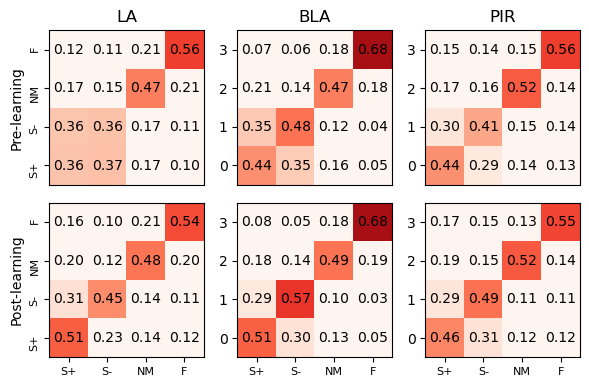

In [13]:
# Cell 2: Load results, normalize confusion matrices, and plot

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
savepath = cwd / "Figure3G"

def normalize_confusion_matrix(cmatrix):
    return cmatrix.astype("float") / cmatrix.sum(axis=1)[:, np.newaxis]

def displayvalues(cmatrix, ax):
    """Overlay numbers onto confusion matrix cells."""
    for i in range(cmatrix.shape[0]):
        for j in range(cmatrix.shape[1]):
            ax.text(j, i, format(cmatrix[i, j], ".2f"),
                    ha="center", va="center", color="black")

# Load confusion matrices
LAcmatrix = np.load(savepath / "experiment1LA_confusionmatrix.npy")
BLAcmatrix = np.load(savepath / "experiment1BLA_confusionmatrix.npy")
PIRcmatrix = np.load(savepath / "experiment1PIR_confusionmatrix.npy")

areas = ["LA", "BLA", "PIR"]
timeperiods = [[13, 17]]
timeperiodtitle = ["Sensory"]

for tp, title in zip(timeperiods, timeperiodtitle):
    fig, ax = plt.subplots(2, 3, figsize=(6, 4))

    for i, cmatrix in enumerate([LAcmatrix, BLAcmatrix, PIRcmatrix]):
        precmatrix = normalize_confusion_matrix(np.mean(cmatrix[:, :, tp[0]:tp[1], 0], axis=2))
        postcmatrix = normalize_confusion_matrix(np.mean(cmatrix[:, :, tp[0]:tp[1], 1], axis=2))

        ax[0, i].imshow(precmatrix, cmap="Reds", vmin=0.25, vmax=0.75)
        displayvalues(precmatrix, ax[0, i])

        cb = ax[1, i].imshow(postcmatrix, cmap="Reds", vmin=0.25, vmax=0.75)
        displayvalues(postcmatrix, ax[1, i])

        ax[0, i].set_title(areas[i])
        ax[0, i].set_xticks([]); ax[1, i].set_xticks([0, 1, 2, 3])
        ax[1, i].set_xticklabels(["S+", "S-", "NM", "F"], fontsize=8)
        ax[0, i].set_yticks([0,1,2,3]); ax[1, i].set_yticks([0,1,2,3])
        ax[0,i].set_ylim(-0.5, 3.5)
        ax[1,i].set_ylim(-0.5,3.5)

    ax[0, 0].set_ylabel("Pre-learning", rotation=90)
    ax[1, 0].set_ylabel("Post-learning", rotation=90)
    ax[0, 0].set_yticks([0, 1, 2, 3]); ax[1, 0].set_yticks([0, 1, 2, 3])
    ax[0, 0].set_yticklabels(["S+", "S-", "NM", "F"], fontsize=8, rotation=90)
    ax[1, 0].set_yticklabels(["S+", "S-", "NM", "F"], fontsize=8, rotation=90)

    plt.tight_layout()
    plt.show()
    plt.savefig(savepath / f"confusionmatrix_LABLAPIR_{title}.png", format="png")
    plt.close()
